In [6]:
import os, sys
import re
import base64
import codecs
from pathlib import Path
from bs4 import BeautifulSoup, Comment
from pymystem3 import Mystem
import pandas as pd
import numpy as np
import multiprocessing as mp
import urllib
import pickle
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from collections import Counter

import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import networkx as nx

py.init_notebook_mode(connected=True)

In [2]:
def decode(s):
    s = base64.b64decode(s)
    s = codecs.decode(s, 'cp1251', errors='ignore')
    return s

In [3]:
def preprocess(parse_html=True):
    html_dir = Path('byweb_html')
    if not html_dir.exists():
        html_dir.mkdir(parents=True)
    
    xmls = [f'byweb.{i}.xml' for i in range(10)]
    urls = []

    for xml_name in xmls:
        byweb = Path('byweb_for_course', xml_name)
        with byweb.open('r') as src:
            raw_xml = src.read()
            print(f'{xml_name} size={len(raw_xml)}')

        soup = BeautifulSoup(raw_xml)
        documents = soup.find_all('document')

        for i, document in enumerate(documents):
            doc_id = document.docid.string
            doc_url = decode(document.docurl.string)
            
            if parse_html:
                doc_html = decode(document.content.string)
                html_path = Path('byweb_html', f'{doc_id}.html')
                with html_path.open('w') as dst:
                    dst.write(doc_html)

            urls.append((doc_id, doc_url))

            if (i + 1) % (len(documents) // 10) == 0:
                print(f'{10 * (i + 1) // (len(documents) // 10)}% done')

    urls = {'html_id': [html_id for html_id, _ in urls], 'html_url': [html_url for _, html_url in urls]}
    pd.DataFrame.from_dict(urls).to_csv('urls.csv', index=False)

In [4]:
def is_comment(text):
    text = text.string.strip()
    return (text.startswith('<!--') and text.endswith('-->')) or (text.startswith('/*') and text.endswith('*/'))


def process_document(doc_path, process_text=True, process_links=True):
    doc_id = doc_path.name.replace('.html', '')
    with doc_path.open('r') as src:
        raw_html = src.read()
    
    soup = BeautifulSoup(raw_html, 'html.parser')
    for element in soup.find_all(text=is_comment):
        element.extract()
    for element in soup(['script', 'style']):
        element.extract()
        
    if process_text:
        title = soup.title.string
        text = soup.get_text(' ')
        text = re.sub('\s+', ' ', text)
        
        text_dir = Path('byweb_text')
        if not text_dir.exists():
            text_dir.mkdir(parents=True)

        with (text_dir / f'{doc_id}.txt').open('w') as dst:
            dst.write(title + '\n' + text)
    
    if process_links:
        links = [link.get('href') for link in soup.find_all('a')]
        links = list(filter(lambda link: link is not None, links))
   
        link_dir = Path('byweb_link')
        if not link_dir.exists():
            link_dir.mkdir(parents=True)
            
        with (link_dir / f'{doc_id}.txt').open('w') as dst:
            dst.write('\n'.join(links))


def process_documents(process_text=True, process_links=True):
    html_dir = Path('byweb_html')
    
    pool = mp.Pool(mp.cpu_count())
    for html in html_dir.iterdir():
        pool.apply_async(process_document, args=(html, process_text, process_links), callback=None)
    pool.close()
    pool.join()

In [5]:
# preprocess(False)
# process_documents(True, False)

In [6]:
def normalize(url):
    # tmp = urllib.parse.urlparse(url)
    # return tmp.netloc + tmp.path
    return url


def add_edges(page_id, src_page):
    edges = []
    src_page = normalize(src_page)
    
    p = Path('byweb_link', f'{page_id}.txt')
    if not p.exists():
        return ''
    
    with Path('byweb_link', f'{page_id}.txt').open('r') as f:
        for link in f.readlines():
            if link.startswith('www.'):
                link = '//' + link
            try:
                dst_page = urllib.parse.urljoin(src_page, link)
                dst_page = normalize(dst_page)
                if '.by' in dst_page:
                    edges.append(src_page + '\t' + dst_page)
            except: pass
    return '\n'.join(edges)


def init_graph():
    urls = pd.read_csv('urls.csv')
    
    pool = mp.Pool(mp.cpu_count())
    edges = [pool.apply(add_edges, args=(row['html_id'], normalize(row['html_url']))) for _, row in urls.iterrows()]
    pool.close()
    pool.join()
    
    edges = [e.split('\t') for es in edges for e in es.split('\n')]
    edges = list(filter(lambda e : len(e) == 2, edges))
    
    vert = {row['html_url']: row['html_id'] for _, row in urls.iterrows()}
    edges = list(filter(lambda e : e[1] in vert, edges))
    
    graph = {'src': [vert[v] for v, _ in edges], 'dst': [vert[u] for _, u in edges]}
    pd.DataFrame.from_dict(graph).to_csv('url_graph.csv', index=False, sep=',')

In [7]:
# init_graph()

In [8]:
def merge_texts():
    text_dir = Path('byweb_text')
    texts = {'id': [], 'text': []}
    for p in text_dir.iterdir():
        id = p.name.replace('.txt', '')
        with p.open('r') as src:
            text = src.read()
            texts['id'].append(id)
            texts['text'].append(text)
    pd.DataFrame.from_dict(texts).to_csv('texts.csv', index=False, sep=',')

In [9]:
# merge_texts()

In [16]:
def build_graph(size):
    df = pd.read_csv('url_graph.csv')
    indeg = {}
    for ind, row in df.iterrows():
        v, u = row['src'], row['dst']
        if u not in indeg:
            indeg[u] = 0
        indeg[u] += 1
    vert = [(deg, v) for v, deg in indeg.items()]
    vert.sort(key=lambda x : -x[0])
    vert = [v for deg, v in vert[:size]]
    
    edges = []
    for ind, row in df.iterrows():
        v, u = row['src'], row['dst']
        if v in vert and u in vert:
            edges.append((v, u))
    return edges, indeg

In [17]:
E, D = build_graph(300)

In [18]:
def draw_graph(E, D):
    urls = pd.read_csv('urls.csv')
    urls = {row['html_id']: row['html_url'] for index, row in urls.iterrows()}
    
    V = set(u for _, u in E)
    G = nx.MultiDiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    
    # nx.kamada_kawai_layout(G).items()
    for v, p in nx.spring_layout(G, k=0.5).items():
        G.node[v]['pos'] = p
    
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x, node_y = [], []
    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Incoming Edges',
                xanchor='left',
                titleside='right'
            ),
            line_width=2)
    )
    
    node_adjacencies = []
    node_text = []
    for node in G.nodes():
        node_adjacencies.append(D[node])
        node_text.append(urls[node])
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ 
                    dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 
                    ) 
                ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
             )
    )
    py.iplot(fig)

In [19]:
draw_graph(E, D)

In [14]:
def get_collection_features():
    docs = pd.read_csv('texts.csv')
    docs = docs.astype({'id': 'int32', 'text': 'str'})
    docs_ids = set(docs['id'])
    
    htmls = pd.read_csv('html_size.csv')
    htmls = htmls.astype({'id': 'int32', 'size': 'int32'})
    
    words = np.array([len(row['text'].split()) for _, row in docs.iterrows()])
    chars = np.array([len(row['text']) for _, row in docs.iterrows()])
    bytes = np.array([len(row['text'].encode('utf-8')) for _, row in docs.iterrows()])
    html_chars = np.array([row['size'] for _, row in htmls.iterrows() if row['id'] in docs_ids])
    
    print(f'#documents=200000')
    print(f'avg #words={np.average(words)}')
    print(f'avg #bytes={np.average(bytes)}')
    print(f'avg #bytes/#html_bytes={np.average(chars / html_chars)}')
    
    words = np.random.choice(words[words <= 10000], 2000)
    bytes = np.random.choice(bytes[bytes <= 100000], 2000)
    fig1 = ff.create_distplot([words], ['words'], bin_size=[250])
    fig2 = ff.create_distplot([bytes], ['bytes'], bin_size=[2500])
    py.iplot(fig1)
    py.iplot(fig2)

In [15]:
get_collection_features()

#documents=200000
avg #words=823.1716775009029
avg #bytes=9914.51162172465
avg #bytes/#html_bytes=0.3567964278492451


In [ ]:
def read_text(path):
    df = pd.read_csv(path, skiprows=0)
    text = df['text'].to_numpy()
    return text

text = read_text('texts.csv')

In [ ]:
def extract_lemmas():
    m = Mystem()
    lemmas = Counter()
    idf = Counter()
    for t in tqdm_notebook(text):
        cleaned = ''.join([i.lower() for i in str(t) if i.isalpha() or i in [' ', '\n', '\t']]).strip()
        stripped = list(map(lambda x: x.strip(), m.lemmatize(cleaned)))
        lemmas.update(stripped)
        idf.update(set(stripped))
    for c in [lemmas, idf]:
        del c['']
        del c['\n']
        del c['\t']
    return lemmas, idf

In [ ]:
def save_lemmas(lemmas, idf):
    with open('lemmas.pickle', 'wb') as f:
        pickle.dump((lemmas, idf), f)

In [7]:
def load_lemmas():
    with open('lemmas.pickle', 'rb') as f:
        return pickle.load(f)

In [42]:
# lemmas, idf = extract_lemmas()
lemmas, idf = load_lemmas()
bad = []
for word in lemmas:
    if len(word) > 25:
        bad.append(word)
for word in bad:
    del lemmas[word]
    del idf[word]

In [50]:
def read_stops():
    with open('russian', 'r') as f:
        return f.read().split('\n')

stop_words = read_stops()

total = sum([lemmas[word] for word in lemmas])

def stop_frequency(counter):
    stop = 0
    for word in counter:
        if word in stop_words:
            stop += counter[word]

    print(f'Percent of stop words in the collection is: {stop / total * 100}%')
    
def average_len(counter):
    vocabulary_len = 0
    collection_len = 0
    for word in counter:
        collection_len += len(word) * counter[word]
        vocabulary_len += len(word)

    print(f'Average length of the word in collection is: {collection_len / total}')
    print(f'Average length of the word in vocabulary is: {vocabulary_len / len(counter)}')
    
def latin_frequency(counter):
    latin_collection = 0
    latin_vocabulary = 0
    for word in counter:
        if 'a' <= word[0] <= 'z':
            latin_collection += counter[word]
            latin_vocabulary += 1
    
    print(f'Percent of latin words in the collection is: {latin_collection / total * 100}%')
    print(f'Percent of latin words in the vocabulary is: {latin_vocabulary / len(counter) * 100}%')

def top_frequency(counter):
    limit = 25
    for word in counter:
        counter[word] /= total
    print(f"Top {limit} most frequent words")
    print(counter.most_common(25))
    
    print(f"Top {limit} words by inverse frequency")
    print(idf.most_common(25))

def top_frequency_without_stops(counter):
    limit = 25
    words_cnt = counter.copy()
    for stop in stop_words:
        del words_cnt[stop]
    total = sum([words_cnt[word] for word in words_cnt])
    for word in words_cnt:
        words_cnt[word] /= total
    print(f"Top {limit} most frequent words excluding stop words")
    print(words_cnt.most_common(25))
    
def build_rank_frequency_plot(counter):
    xs = np.array(counter.most_common(len(counter)))[:, 1].astype('float32') 
    ys = np.arange(1, len(counter) + 1)
    xs = np.log(xs)
    ys = np.log(ys)
    plt.legend("Rank(frequency)")
    plt.xlabel("log(frequency)")
    plt.ylabel("log(rank)")
    plt.plot(xs, ys)

In [51]:
stop_frequency(lemmas)
average_len(lemmas)
latin_frequency(lemmas)
top_frequency_without_stops(lemmas)
top_frequency(lemmas)

Percent of stop words in the collection is: 20.32295638143297%
Average length of the word in collection is: 6.0961295766517365
Average length of the word in vocabulary is: 10.40738837312413
Percent of latin words in the collection is: 13.27699064013268%
Percent of latin words in the vocabulary is: 36.37969499842349%
Top 25 most frequent words excluding stop words
[('сообщение', 0.005270780111372903), ('весь', 0.004170823957928776), ('a', 0.004085098558279545), ('год', 0.0038637167539854705), ('это', 0.003831580828842465), ('г', 0.003471763248649125), ('беларусь', 0.003444937432164732), ('форум', 0.0029555372170966), ('новость', 0.0029496144035927635), ('мочь', 0.0029144682329058295), ('который', 0.0028799347670641203), ('url', 0.0027210932558847695), ('сайт', 0.0026322155342057597), ('свой', 0.002599751057189229), ('добавлять', 0.002506708718518766), ('работа', 0.002505154756954791), ('минск', 0.0023815126951445675), ('новый', 0.002378946438618917), ('день', 0.0022731527353434928), ('а

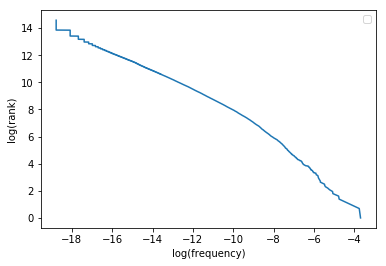

In [20]:
build_rank_frequency_plot(lemmas)